In [79]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from scipy.ndimage.filters import correlate
Epsilon = 1e-7
DPI = 120
RADIUS = 2
THICKNESS = 2
COLOR = [255,0,0]

C:\Users\fadri_zkxoohp\AppData\Local\Temp\ipykernel_10932\184973183.py:5: DeprecationWarning: Please use `correlate` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import correlate


### load image and compute the gradient

In [80]:
# TODO 
input_img = cv2.imread('inputs/I1.jpg', 0) / 255
dy, dx = np.gradient(input_img)



### Compute structure tensor

In [81]:
# TODO 
# Calculate the gradient in the x and y directions
gradient_x = cv2.Sobel(input_img, cv2.CV_64F, 1, 0, ksize=5)
gradient_y = cv2.Sobel(input_img, cv2.CV_64F, 0, 1, ksize=5)

Ixx = gradient_x * gradient_x
Ixy = gradient_x * gradient_y
Iyy = gradient_y * gradient_y

Ixx = gaussian_filter(Ixx, sigma=1)
Ixy = gaussian_filter(Ixy, sigma=1)
Iyy = gaussian_filter(Iyy, sigma=1)


### Compute Shi-Thomasi response and Harris response, please compare them in the end

M:  (2, 2, 2448, 3264)


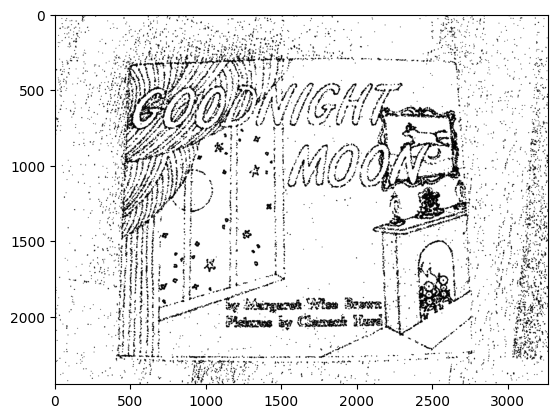

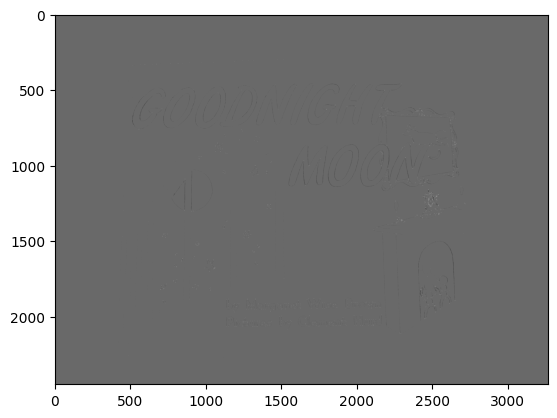

In [108]:
from numpy import linalg as LA
# TODO 
# Constuct the matrix M out of Ixx, Ixy, Iyy
def shitomasi(img, Ixx, Iyy, Ixy):
    M = np.array([[Ixx, Ixy], [Ixy, Iyy]])

    print('M: ' , M.shape)


    sqrt_part = np.sqrt((Ixx - Iyy)**2 + 4 * Ixy**2)

    lambda1 = 0.5 * (Ixx + Iyy + sqrt_part)
    lambda2 = 0.5 * (Ixx + Iyy - sqrt_part)

    # Find the smaller eigenvalue for each pixel
    smaller_eigenvalues = np.minimum(lambda1, lambda2)

    mean_smaller_eigenvalues = np.mean(smaller_eigenvalues)

    #Eigenvalue < 5 * mean
    selected_pixels = np.where(smaller_eigenvalues > 5 * mean_smaller_eigenvalues, smaller_eigenvalues, 0)


    # Apply dilation - this gives the maximum in the 5x5 neighborhood
    dilated = cv2.dilate(selected_pixels, np.ones((5,5)))

    # Non-maximum suppression: wherever the original image is less than the dilated one, suppress it
    non_max_suppression = np.where(selected_pixels < dilated, 0, 1)

    new_image = np.zeros_like(non_max_suppression, dtype=np.uint8)  
    new_image[non_max_suppression > 0] = 255  # set the selected pixels to white

    # Display the image
    plt.imshow(new_image, cmap='gray')
    plt.show()

    return new_image


# response_harris = cv2.cornerHarris(input_img, 2, 3, 0.04)

def response_harris_diy(Ixx, Ixy, Iyy, k=0.03):
    det = Ixx * Iyy - Ixy**2
    trace = Ixx + Iyy
    return det - k * trace**2

response_harris_diy = response_harris_diy(Ixx, Ixy, Iyy)
# set every value below 0.001 to 0 and the rest to 255
# response_harris_diy = np.where(response_harris_diy < 0.001, 0, 1)
response_shitomasi = shitomasi(input_img, Ixx, Iyy, Ixy)


#show the response harris image
plt.imshow(response_harris_diy, cmap='gray')



### Visualise the response map

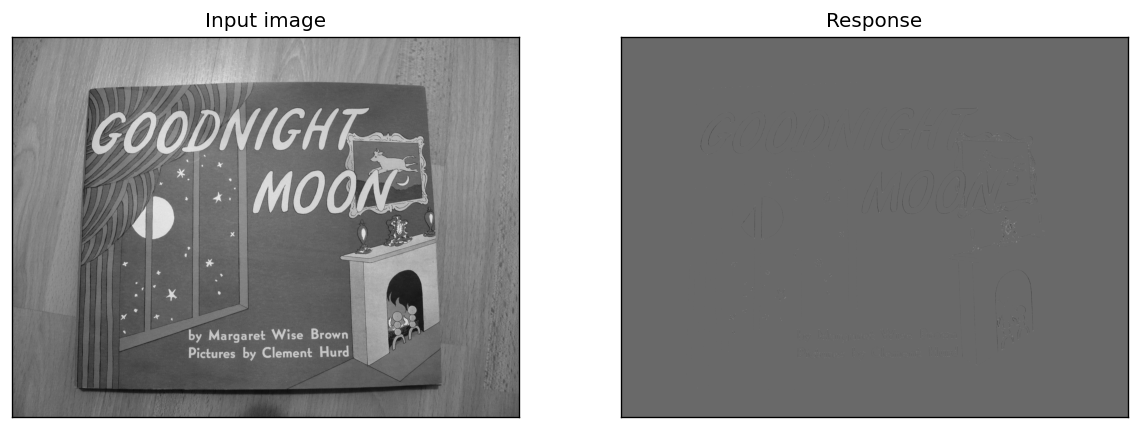

In [109]:
# choose either Shi-Tomasi or Harris response
# TODO 
response = response_harris_diy


plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(input_img, cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(response, cmap=plt.cm.gray)
plt.title('Response')
plt.show()

### Plot the histogram of responses

(array([7.372112e+06, 3.729000e+03, 1.024000e+03, 3.360000e+02,
        1.190000e+02, 4.500000e+01, 2.300000e+01, 6.000000e+00,
        2.000000e+00, 1.000000e+00]),
 array([1.18097370e-10, 1.71191042e+02, 3.42382084e+02, 5.13573127e+02,
        6.84764169e+02, 8.55955211e+02, 1.02714625e+03, 1.19833730e+03,
        1.36952834e+03, 1.54071938e+03, 1.71191042e+03]),
 <BarContainer object of 10 artists>)

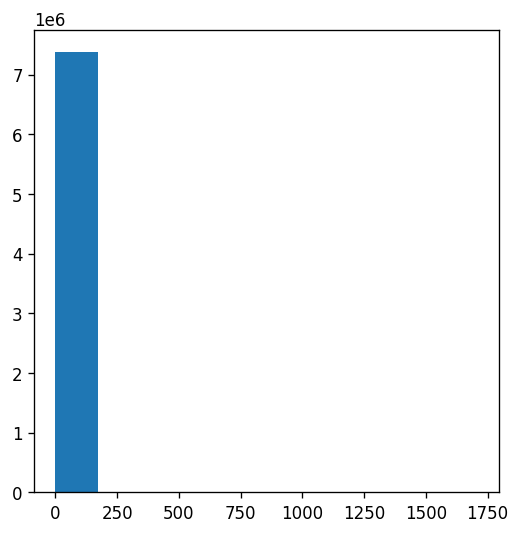

In [110]:
plt.figure(figsize=(5,5), dpi=DPI)
plt.hist(response.flatten()[response.flatten()>0])

### Threshold the corners and visualise it

60


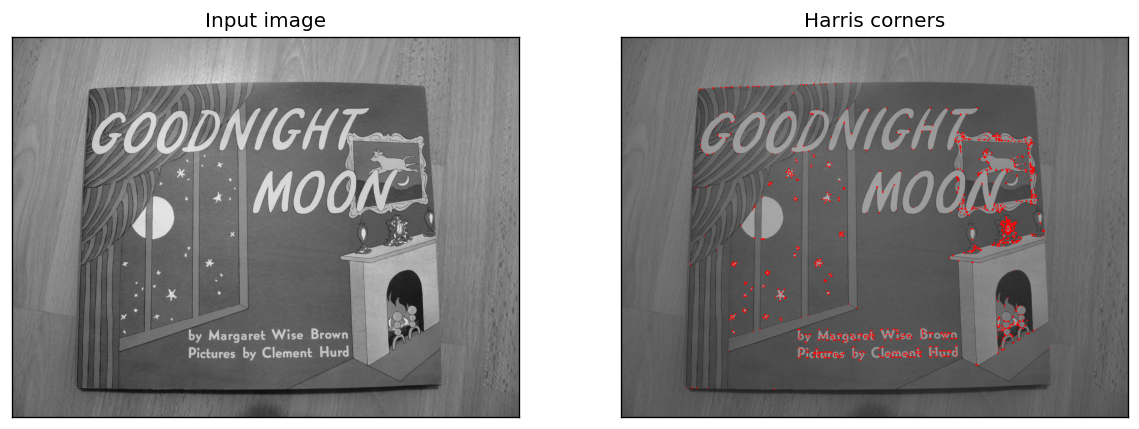

In [114]:
# TODO 
threshold = 60


corners =  cv2.cvtColor((input_img.copy() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
mask = response>threshold

x, y = np.where(mask)
for idx in range(len(x)):
    cv2.circle(corners, (y[idx],x[idx]), RADIUS, COLOR, THICKNESS)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow((input_img * 255).astype(np.uint8), cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(corners)
plt.title('Harris corners')
plt.show()

### Apply NMS

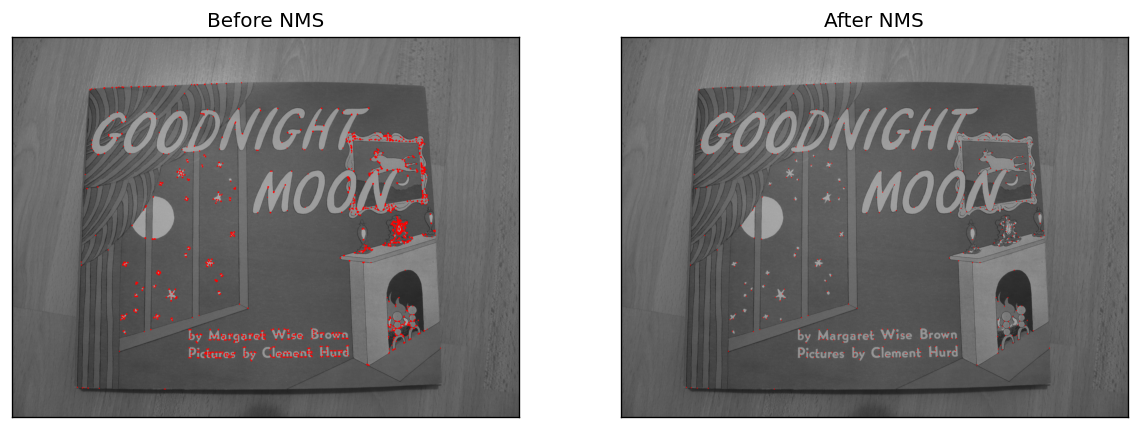

In [117]:
from scipy.ndimage import maximum_filter
# TODO

# Apply non-maximum suppression
max_filtered = maximum_filter(response, size=40, mode='constant')
mask = (response == max_filtered) & (response > threshold)


corners_filter =  cv2.cvtColor((input_img.copy() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
x, y = np.where(mask)
for idx in range(len(x)):
    cv2.circle(corners_filter, (y[idx],x[idx]), RADIUS, COLOR, THICKNESS)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(corners)
plt.title('Before NMS')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(corners_filter)
plt.title('After NMS')
plt.show()